In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
import json
import wandb

from src.net import InstanceGCN
from src.dataset import MultiTargetDataset
from src.utils import normalize_curve, compute_integral

In [4]:
results_dir = Path('../data/results/')
opts_dir = Path('../data/interim/')

all_shortnames = {'_'.join(fp.name.split('_')[:2]) for fp in results_dir.glob('*.json')}
all_shortnames
for shortname in all_shortnames:
    print(shortname)
    print(len(list(results_dir.glob(shortname+'_*.json'))))

tr_200
120
ws_200
120
tr_-1
120
ws_500
120
ef_200
120
ws_1000
120
tr_500
120
ws_-1
120
tr_1000
120
ef_1000
120
bs_0
120
ef_500
120


In [5]:
def load_all_results(shortname: str):
    results = list()
    for result_fpath in results_dir.glob(shortname+'_*.json'):
        size = int(result_fpath.name.split('_')[3])
        size_id = int(result_fpath.name.split('_')[4][:-len('.json')])

        with open(result_fpath) as f:
            result = json.load(f)

        solution_fpath = opts_dir/f"97_{size}_{size_id}_opt.npz"
        solution_npz = np.load(solution_fpath)
        quasi_optimal_objective = solution_npz['arr_0'].astype('uint32')

        results.append(dict(
            size=size,
            size_id=size_id,
            opt_obj=quasi_optimal_objective,
            **result
        ))
    df = pd.DataFrame(results)
    df['primal_curve'] = df['primal_curve'].apply(normalize_curve)
    df['primal_curve'] = df['primal_curve'] / df['opt_obj']

    return df

dfs = {shortname: load_all_results(shortname) for shortname in all_shortnames}
dfs['tr_1000']

,size,size_id,opt_obj,infeasible,runtime,objective,gap,primal_curve
0,9,78,3782,False,2.729626,3782.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,9,62,3888,False,3.917893,3888.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,18,67,8618,False,120.000232,8116.0,0.187627,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,13,73,6757,False,120.002052,6752.0,0.015932,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,24,62,13741,False,120.000042,13465.0,0.045982,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
115,18,71,9005,False,120.000347,8955.0,0.032018,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
116,20,78,8558,False,120.004032,8273.0,0.175805,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
117,13,61,6540,False,120.000165,6540.0,0.007162,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
118,20,71,8799,True,120.000362,0.0,-1.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [6]:
infeasibilities = list()
sns = list()
for sn in dfs.keys():
    df = dfs[sn]
    infeasibility = df['infeasible'].sum() / df.shape[0]

    sns.append(sn)
    infeasibilities.append(infeasibility)

pd.Series(infeasibilities, index=sns, name='infeasibility rate').sort_index()

bs_0       0.025000
ef_1000    0.558333
ef_200     0.066667
ef_500     0.233333
tr_-1      1.000000
tr_1000    0.041667
tr_200     0.025000
tr_500     0.025000
ws_-1      0.025000
ws_1000    0.025000
ws_200     0.025000
ws_500     0.025000
Name: infeasibility rate, dtype: float64

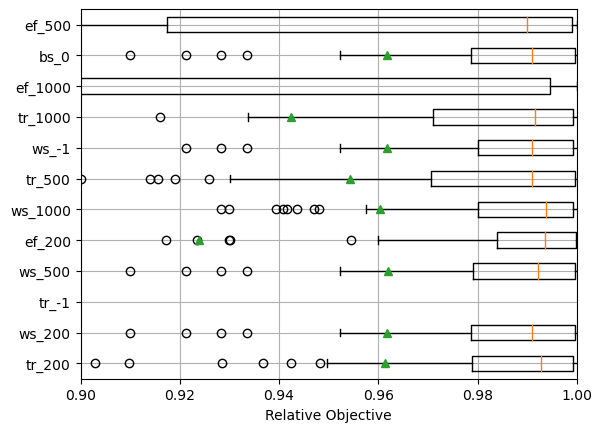

In [7]:
rel_objs = list()
sns = list()
for sn, df in dfs.items():
    rel_objs.append((df['objective'] / df['opt_obj']).values)
    sns.append(sn)
    # (df['objective'] / df['opt_obj']).plot.box(showmeans=True)
plt.boxplot(rel_objs, labels=sns, vert=False, showmeans=True)
plt.xlim(0.9,1)
plt.xlabel('Relative Objective')
plt.grid()
plt.show()

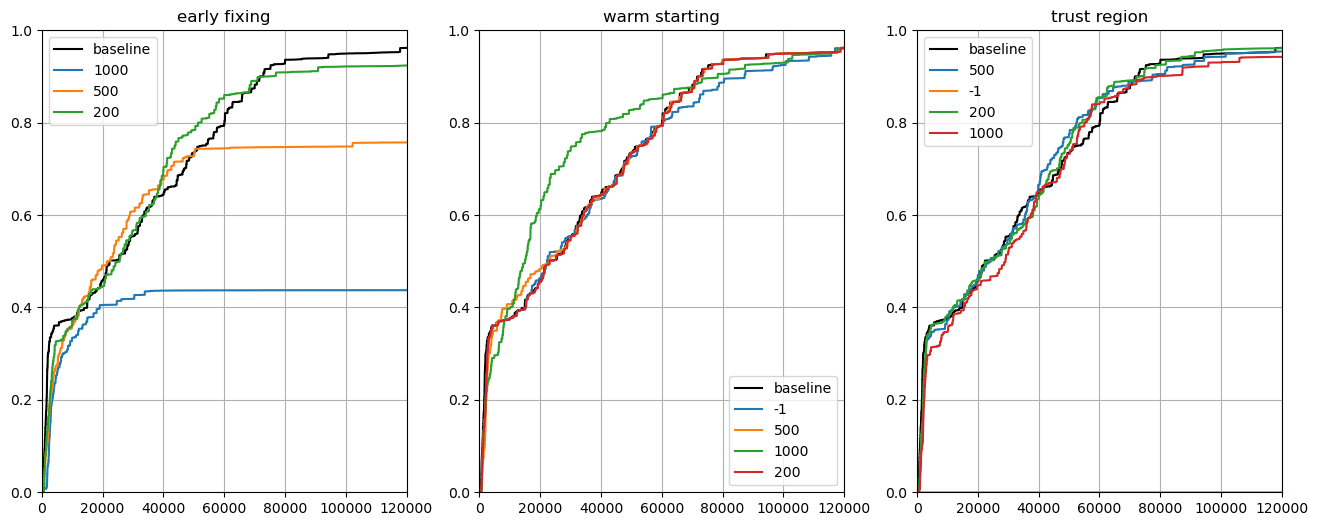

In [18]:
# TODO: baseline is different for every method, as it should take on account the
# feasibility

fig, axs = plt.subplots(1,3)

fig.set_size_inches(16,6)

axs[0].set_title('early fixing')
axs[1].set_title('warm starting')
axs[2].set_title('trust region')

for sn, df in dfs.items():
    if sn.startswith('ef'):
        ax = axs[0]
    elif sn.startswith('ws'):
        ax = axs[1]
    elif sn.startswith('tr'):
        ax = axs[2]
    else:
        for ax in axs:
            ax.plot(df['primal_curve'].mean(), color='black', label='baseline')
        continue
    ax.plot(df['primal_curve'].mean(), label=sn[3:])
# plt.plot(df[~df['infeasible']]['primal_curve'].mean())

for ax in axs:
    ax.set_xlim(0,120/1e-3)
    ax.set_ylim(0,1)
    ax.legend()
    ax.grid()
plt.show()

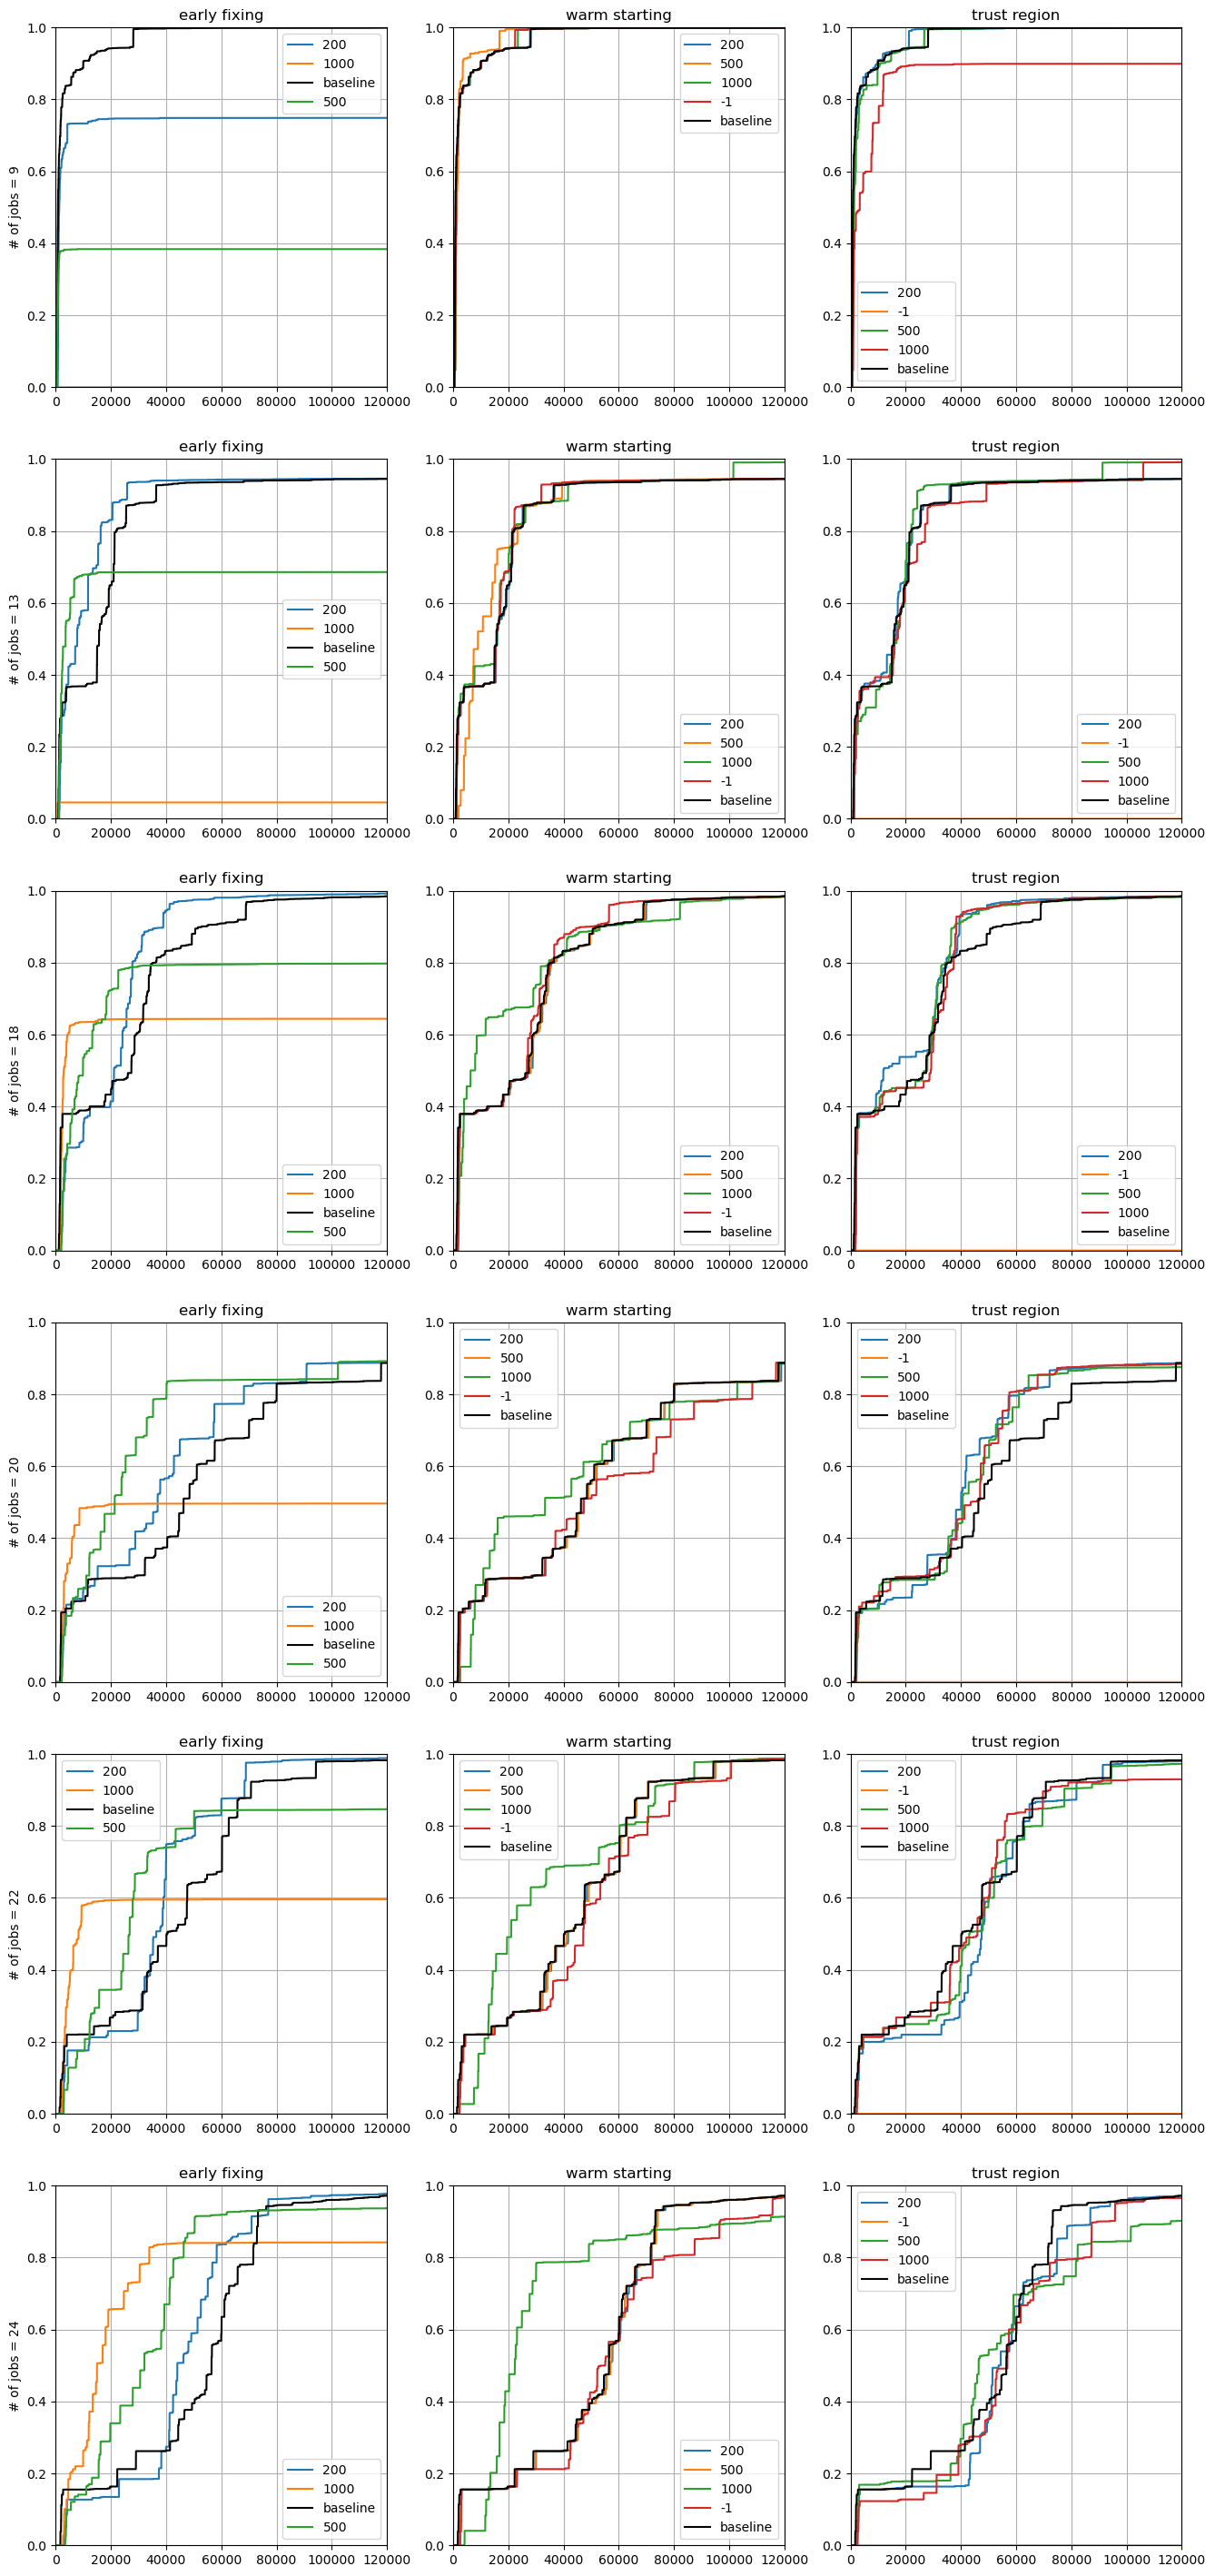

In [12]:
# TODO: baseline is different for every method, as it should take on account the
# feasibility

sizes = sorted(dfs['bs_0']['size'].unique())

fig, axss = plt.subplots(len(sizes),3)

fig.set_size_inches(16,len(sizes) * 6)

for i, s in enumerate(sizes):
    axs = axss[i]

    axs[0].set_title('early fixing')
    axs[1].set_title('warm starting')
    axs[2].set_title('trust region')

    for sn, df_ in dfs.items():
        df = df_[df_['size'] == s]

        if sn.startswith('ef'):
            ax = axs[0]
        elif sn.startswith('ws'):
            ax = axs[1]
        elif sn.startswith('tr'):
            ax = axs[2]
        else:
            for ax in axs:
                ax.plot(df['primal_curve'].mean(), color='black', label='baseline')
            continue
        ax.plot(df['primal_curve'].mean(), label=sn[3:])
    # plt.plot(df[~df['infeasible']]['primal_curve'].mean())

    for ax in axs:
        ax.set_xlim(0,120/1e-3)
        ax.set_ylim(0,1)
        ax.legend()
        ax.grid()

    axs[0].set_ylabel(f'# of jobs = {s}')
plt.show()